In [13]:
import cupy as np
from numpy import linalg as LA
from copy import deepcopy
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

from IPython.display import display as d

In [14]:
trainxs = np.load("../comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((1, 0, 2)).reshape(784, -1)
trainys = np.load("../comp0090_assignment_1_data/fashion-train-labels.npz").reshape((1, -1))
devxs   = np.load("../comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((1, 0, 2)).reshape(784, -1)
devys   = np.load("../comp0090_assignment_1_data/fashion-dev-labels.npz").reshape((1, -1))

In [15]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(784, 12000)
(1, 12000)
(784, 1000)
(1, 1000)


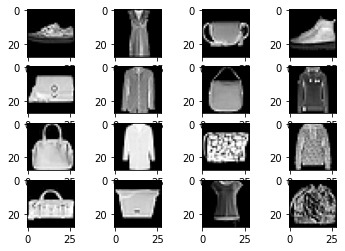

In [16]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[:, np.random.randint(0, len(devxs))].reshape(28, 28).get())

# Q4 - Two-layer MLP

In [5]:
# Hyperparameters
learning_rate = alpha = 0.01
epochs = 50
momentum_coefficient = 0.9

Din = trainxs[0].shape[0] # trainxs.shape == (12000, 748, 1)
h1 = 23
Dout = 1

In [6]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def dSigmoid(Z):
    s = sigmoid(Z)
    return s * (1 - s)

In [7]:
class twolp:
    def __init__(self, xs, ys):
        self.X = xs
        self.Y = ys
        
        self.L = 2
        self.dims = [28**2, h1, 1]
        
        self.param = {}
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))        
        self.param['w2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))   
        
        self.ch = {} #cache
        self.grad = {}
        
        self.epoch = []
        self.loss = []
        self.val_loss = []
        self.accuracy = []
        self.lr = 0.05
        self.nData = self.Y.shape[1]
    
    def nloss(self,Yh):
        loss = (1./self.nData) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
        return loss
    
    def forward_general(self, xs):
        Z1 = self.param["W1"] @ xs + self.param["b1"]
        A1 = sigmoid(Z1)
        Z2 = self.param["w2"] @ A1 + self.param["b2"]
        A2 = sigmoid(Z2)
        return Z1, A1, Z2, A2
    
    def forward(self):
        Z1, A1, Z2, A2 = self.forward_general(self.X)
        
        self.ch["Z1"], self.ch["A1"] = Z1, A1
        self.ch["Z2"], self.ch["A2"] = Z2, A2
            
        loss = self.nloss(A2).item()
        return loss
    
    def backward(self):
        grad_Z2 = self.ch["A2"] - self.Y
        grad_A1 = np.dot(self.param["w2"].T, grad_Z2)
        grad_W2 = 1./self.ch['A1'].shape[1] * np.dot(grad_Z2, self.ch['A1'].T)
        grad_b2 = 1./self.ch['A1'].shape[1] * np.dot(grad_Z2, np.ones([grad_Z2.shape[1],1]))
        self.grad["w2"], self.grad["b2"] = grad_W2, grad_b2
                            
        grad_Z1 = grad_A1 * dSigmoid(self.ch['Z1'])        
        grad_W1 = 1./self.X.shape[1] * np.dot(grad_Z1,self.X.T)
        grad_b1 = 1./self.X.shape[1] * np.dot(grad_Z1, np.ones([grad_Z1.shape[1],1]))
        self.grad["W1"], self.grad["b1"] = grad_W1, grad_b1
        
        self.param["W1"] = self.param["W1"] - self.lr * grad_W1
        self.param["b1"] = self.param["b1"] - self.lr * grad_b1
        self.param["w2"] = self.param["w2"] - self.lr * grad_W2
        self.param["b2"] = self.param["b2"] - self.lr * grad_b2
        
    def forward_test(self, xs):
        A1 = sigmoid(self.param["W1"] @ xs + self.param["b1"])
        A2 = sigmoid(self.param["w2"] @ A1 + self.param["b2"])
        return A2
    
    def predict_class(self, xs):
        nn_output = self.forward_test(xs)
        class_preds = nn_output >= 0.5
        return class_preds
    
    def naccuracy(self, xs, ys):
        class_preds = self.predict_class(xs)
        return np.count_nonzero(class_preds == ys) / xs.shape[1]
    
    def train(self, epochs = 3000):
        np.random.seed(1)
    
        for epoch in range(1, epochs + 1):
            loss=self.forward()
            self.backward()
            
            accuracy = self.naccuracy(devxs, devys)
            self.epoch.append(epoch)
            self.loss.append(loss)
            self.accuracy.append(accuracy)
            if epoch % 100 == 1:
                print ("Cost after iteration %i: %f, accuracy: %f" %(epoch, loss, accuracy))

In [8]:
nn = twolp(trainxs, trainys)
nn.train()

Cost after iteration 1: 0.692743, accuracy: 0.533000
Cost after iteration 101: 0.461844, accuracy: 0.889000
Cost after iteration 201: 0.326773, accuracy: 0.940000
Cost after iteration 301: 0.248081, accuracy: 0.962000
Cost after iteration 401: 0.204529, accuracy: 0.962000
Cost after iteration 501: 0.179269, accuracy: 0.963000
Cost after iteration 601: 0.163460, accuracy: 0.961000
Cost after iteration 701: 0.152853, accuracy: 0.962000
Cost after iteration 801: 0.145308, accuracy: 0.963000
Cost after iteration 901: 0.139675, accuracy: 0.965000
Cost after iteration 1001: 0.135296, accuracy: 0.965000
Cost after iteration 1101: 0.131773, accuracy: 0.967000
Cost after iteration 1201: 0.128856, accuracy: 0.968000
Cost after iteration 1301: 0.126379, accuracy: 0.968000
Cost after iteration 1401: 0.124231, accuracy: 0.968000
Cost after iteration 1501: 0.122333, accuracy: 0.968000
Cost after iteration 1601: 0.120628, accuracy: 0.968000
Cost after iteration 1701: 0.119075, accuracy: 0.968000
Cost

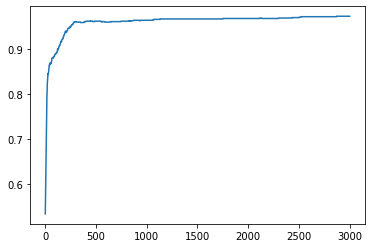

In [9]:
plt.plot(nn.epoch, nn.accuracy)

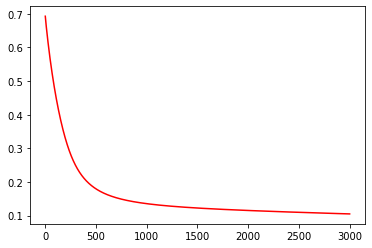

In [10]:
plt.plot(nn.epoch, nn.loss, color="red")

In [11]:
if not models:
    models = {}
    models["nn_0_01"] = nn_0_05

NameError: name 'models' is not defined

In [ ]:
models["nn_0_1"] = nn_0_1

In [ ]:
def st(k):
    plt.plot(models[k].epoch, models[k].accuracy)
    plt.plot(models[k].epoch, models[k].loss, color="red")

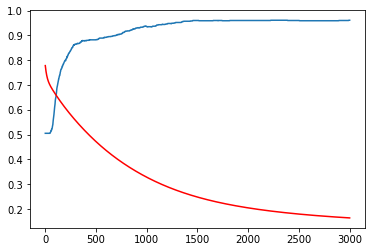

In [115]:
st("nn_0_01")

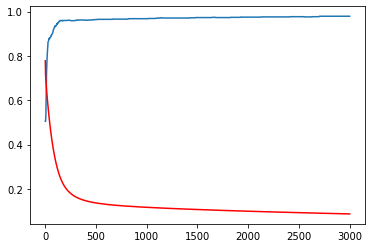

In [117]:
st("nn_0_1")